In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline  # 改用 imblearn 的 Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from imblearn.over_sampling import SMOTE
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/2024-artificial-intelligence-hw-1/sample_submission.csv
/kaggle/input/2024-artificial-intelligence-hw-1/train.csv
/kaggle/input/2024-artificial-intelligence-hw-1/test.csv


## Load Data

In [2]:
# load train.csv
train_df = pd.read_csv("/kaggle/input/2024-artificial-intelligence-hw-1/train.csv")
train_df

,date,close,open,high,low,volume,ht_dcperiod,ht_dcphase,inphase,quadrature,...,var,atr,natr,trange,ad,adosc,obv,1_trend,5_trend,10_trend
0,1,94.86,101.36,103.36,94.36,21789208,16.827667,307.142904,-3.555735,-3.246850,...,10.243520,7.920250,8.349410,9.0,-3.848627e+07,-1.167386e+07,261516573.0,1.0,1.0,1.0
1,2,97.59,96.09,99.09,93.09,13642091,15.896730,-22.568827,-2.639682,1.304832,...,7.281680,7.821542,8.014696,6.0,-4.412492e+07,-1.520909e+07,258865213.0,0.0,1.0,1.0
2,3,97.59,94.09,101.59,92.09,16305307,15.562605,-7.225711,-3.147920,-1.168940,...,6.959584,7.941432,8.137547,9.5,-4.155040e+07,-1.235346e+07,258865213.0,1.0,1.0,1.0
3,4,98.69,100.19,102.69,98.69,14127338,15.367623,6.165014,-3.464886,-0.187496,...,3.781264,7.738472,7.841192,5.1,-5.567774e+07,-1.455727e+07,272992551.0,-1.0,0.0,1.0
4,5,96.50,102.00,103.50,95.50,10304396,15.549624,16.710140,-3.691806,-1.918849,...,3.172496,7.757153,8.038501,8.0,-6.340604e+07,-1.659444e+07,262688155.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1857,1858,131.64,131.64,133.14,131.64,1915360,21.933646,254.843013,1.760688,-0.225027,...,4.348616,2.505854,1.903565,1.5,-1.378997e+09,-1.715582e+06,853638722.0,1.0,-1.0,-1.0
1858,1859,133.34,132.34,134.84,132.34,2765566,20.412209,305.502984,-0.752763,-6.230444,...,0.751400,2.571374,1.928434,2.5,-1.378417e+09,-1.447268e+06,859048286.0,0.0,-1.0,-1.0
1859,1860,134.19,133.19,134.69,132.69,1102925,20.218289,-37.385040,-3.042672,-4.300574,...,0.751400,2.530561,1.885805,2.0,-1.377866e+09,-1.119953e+06,860151211.0,0.0,-1.0,-1.0
1860,1861,133.77,134.27,136.27,133.27,1224191,20.742574,-29.806261,-3.829639,-1.516603,...,0.839464,2.564093,1.916792,3.0,-1.378682e+09,-1.143915e+06,858927020.0,0.0,-1.0,-1.0


## Preprocess

### 更新版 (原始方法就是好方法)

In [3]:
label_trend = ["1_trend", "5_trend", "10_trend"]

# Create feature. Per 30 days data as an example.
def create_lagged_features(df, trend, days=60, period=30):
    features = []
    targets = []
    
    for i in range(days-1, len(df)):
        feature_row = []
        target= df.iloc[i-period][trend]

        # Concat features from day 1 to day 30.
        for j in range(days-1, -1, -1):
            feature_row.extend([
                df.iloc[i - j]['close'],
                df.iloc[i - j]['open'],
                df.iloc[i - j]['high'],
                df.iloc[i - j]['low'],
                df.iloc[i - j]['volume'],
            ])

            
        features.append(feature_row)
        targets.append([target])
    
    return np.array(features), np.array(targets)

# Create feature
features_1d, targets_1d = create_lagged_features(train_df, label_trend[0])
features_5d, targets_5d = create_lagged_features(train_df, label_trend[1])
features_10d, targets_10d = create_lagged_features(train_df, label_trend[2])

In [4]:
# Use for Standardization
# (可以再自己決定要MinMaxScaler()或是StandardScaler())
scaler = StandardScaler()

# Split train set and validation set
X_train_1d, y_train_1d = features_1d[:round(len(features_1d) * 0.8)], targets_1d[:round(len(targets_1d) * 0.8)].ravel()
X_val_1d, y_val_1d = features_1d[round(len(features_1d) * 0.8):], targets_1d[round(len(targets_1d) * 0.8):].ravel()

# # Standardization
X_train_1d = scaler.fit_transform(X_train_1d)
X_val_1d = scaler.transform(X_val_1d)

# Split train set and validation set
X_train_5d, y_train_5d = features_5d[:round(len(features_5d) * 0.8)], targets_5d[:round(len(targets_5d) * 0.8)].ravel()
X_val_5d, y_val_5d = features_5d[round(len(features_5d) * 0.8):], targets_5d[round(len(targets_5d) * 0.8):].ravel()

# # Standardization
X_train_5d = scaler.fit_transform(X_train_5d)
X_val_5d = scaler.transform(X_val_5d)

# Split train set and validation set
X_train_10d, y_train_10d = features_10d[:round(len(features_10d) * 0.8)], targets_10d[:round(len(targets_10d) * 0.8)].ravel()
X_val_10d, y_val_10d = features_10d[round(len(features_10d) * 0.8):], targets_10d[round(len(targets_10d) * 0.8):].ravel()

# # Standardization
X_train_10d = scaler.fit_transform(X_train_10d)
X_val_10d = scaler.transform(X_val_10d)

### 將資料降維 (可跑可不跑)

In [ ]:
n_component = 100 # 要降至的維度 (可以自己調)
pca = PCA(n_components=n_component)

X_train_1d = pca.fit_transform(X_train_1d)
X_val_1d = pca.transform(X_val_1d)

X_train_5d = pca.fit_transform(X_train_5d)
X_val_5d = pca.transform(X_val_5d)

X_train_10d = pca.fit_transform(X_train_10d)
X_val_10d = pca.transform(X_val_10d)

## Training

### 利用 GridSearchCV 來找最佳的參數

In [ ]:
# 定義 SVC 模型和參數網格
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', "sigmoid"],
    'gamma': ["auto", "scale", 1, 0.1, 0.01]
}


test_svc = SVC()


# 因為傳入的df長得一樣，而且features也一樣，同時找最佳參數的時間超級的久，所以其實只要訓練一grid_search_1d就夠了
# 而且也可以將最佳參數記下來後，就直接用，之後就不用訓練了

# 使用 GridSearchCV 尋找最佳參數
grid_search_1d = GridSearchCV(test_svc, param_grid, cv=5, scoring='f1_macro')
# grid_search_5d = GridSearchCV(test_svc, param_grid, cv=5, scoring='f1_macro')
# grid_search_10d = GridSearchCV(test_svc, param_grid, cv=5, scoring='f1_macro')


grid_search_1d.fit(X_train_1d, y_train_1d)
# grid_search_5d.fit(X_train_5d, y_train_5d)
# grid_search_10d.fit(X_train_10d, y_train_10d)

# 提取最佳參數
best_params = grid_search.best_params_

### 訓練並預測模型

In [5]:
# 之前測得的 d1_trend 的最佳參數 (如果事先用GridSearchCV找過的話，可以註解話下面這段)
best_params = {
    'C': 1,  
    'kernel': 'poly',
    'gamma': 0.1,
}


model_1d = SVC(**best_params, probability=True, random_state=42)
model_5d = SVC(**best_params, probability=True, random_state=42)
model_10d = SVC(**best_params, probability=True, random_state=42)

# training model
model_1d.fit(X_train_1d, y_train_1d)
model_5d.fit(X_train_5d, y_train_5d)
model_10d.fit(X_train_10d, y_train_10d)

# Prediction
y_pred_1d = model_1d.predict(X_val_1d)
y_pred_5d = model_5d.predict(X_val_5d)
y_pred_10d = model_10d.predict(X_val_10d)

# Generate Classification Result
print(f"Report for 1_trend:")
print(classification_report(y_val_1d[:], y_pred_1d[:], zero_division=True))
print('---------------------------------------------------')
print(f"Report for 5_trend:")
print(classification_report(y_val_5d[:], y_pred_5d[:], zero_division=True))
print('---------------------------------------------------')
print(f"Report for 10_trend:")
print(classification_report(y_val_10d[:], y_pred_10d[:], zero_division=True))
print('---------------------------------------------------')

Report for 1_trend:
              precision    recall  f1-score   support

        -1.0       0.37      0.58      0.45       105
         0.0       0.53      0.36      0.43       166
         1.0       0.33      0.30      0.31        90

    accuracy                           0.41       361
   macro avg       0.41      0.41      0.40       361
weighted avg       0.43      0.41      0.41       361

---------------------------------------------------
Report for 5_trend:
              precision    recall  f1-score   support

        -1.0       0.58      0.50      0.54       129
         0.0       0.29      0.25      0.27        83
         1.0       0.59      0.69      0.64       149

    accuracy                           0.52       361
   macro avg       0.48      0.48      0.48       361
weighted avg       0.51      0.52      0.52       361

---------------------------------------------------
Report for 10_trend:
              precision    recall  f1-score   support

        -1.0      

## Chart drawing

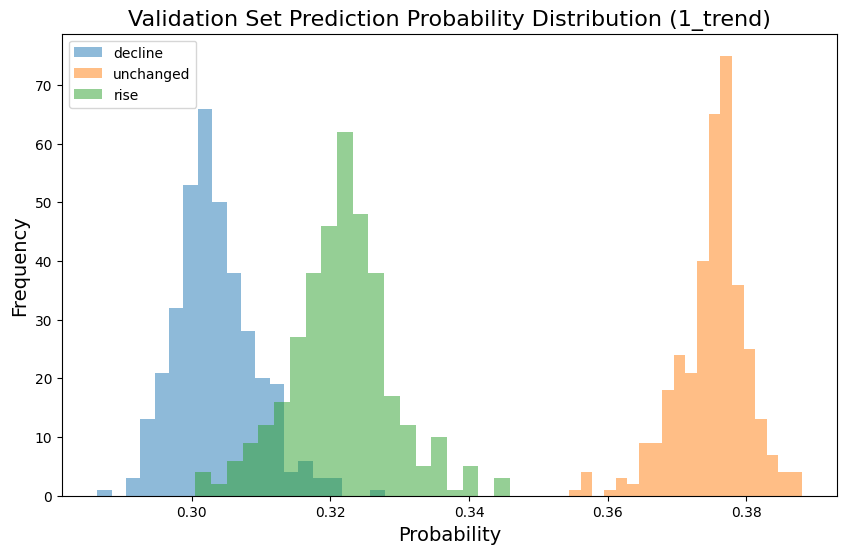

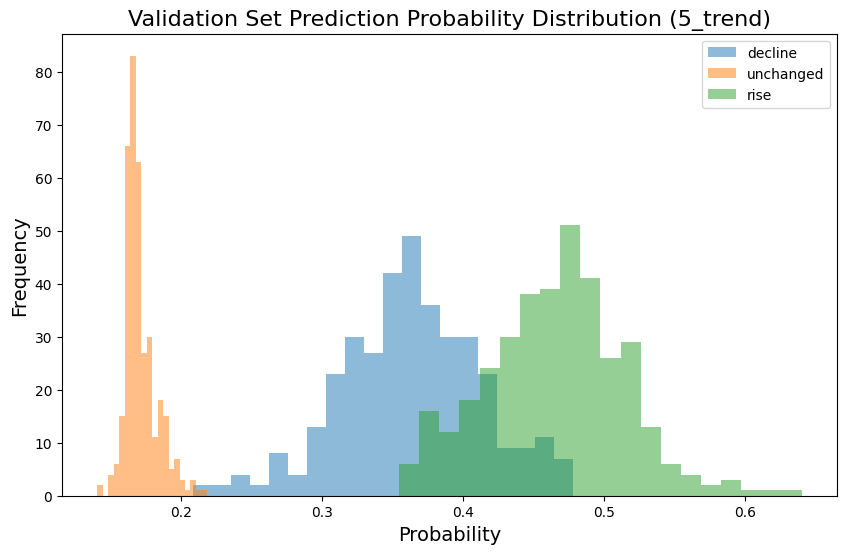

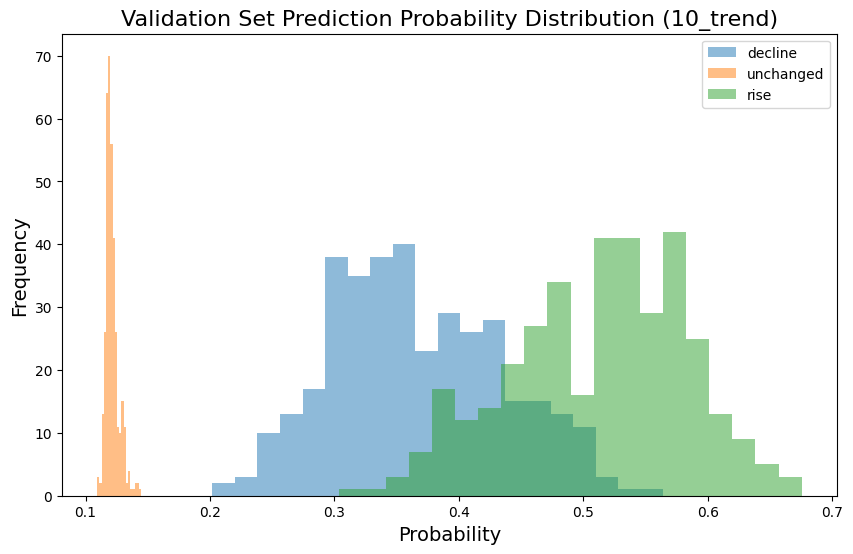

In [6]:
# 繪製驗證集的預測概率分佈圖
class_map = {0: "decline", 1: "unchanged", 2: "rise"}
class_order = [class_map[0], class_map[1], class_map[2]]

# 機率分布
probabilities_d1 =  model_1d.predict_proba(X_val_1d)
probabilities_d5 =  model_5d.predict_proba(X_val_5d)
probabilities_d10 = model_10d.predict_proba(X_val_10d)

prob_dict = {label_trend[0]: probabilities_d1, 
             label_trend[1]: probabilities_d5,
             label_trend[2]: probabilities_d10,
            }

for key, value in prob_dict.items():
    # 繪製驗證集的機率分佈長條圖
    plt.figure(figsize=(10, 6))
    for i in range(value.shape[1]):
        plt.hist(value[:, i], bins=20, alpha=0.5, label=class_order[i])

    plt.title(f'Validation Set Prediction Probability Distribution ({key})', fontsize=16)
    plt.xlabel('Probability', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.legend()
    plt.show()

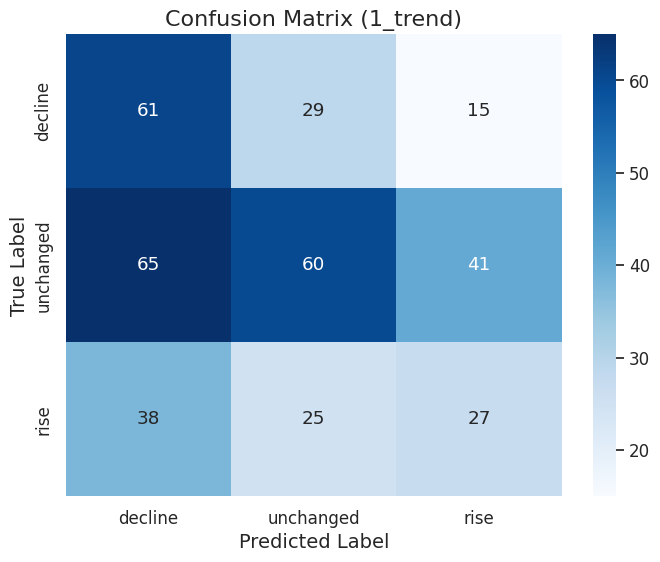

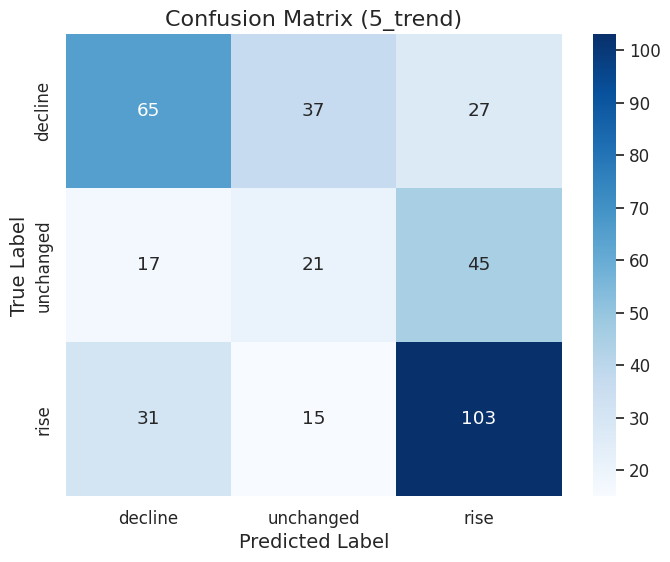

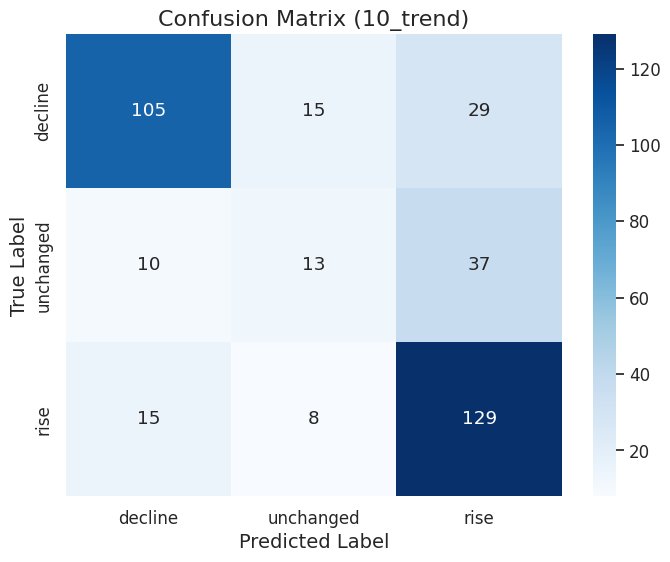

In [7]:
pred_dict = {label_trend[0]: [y_val_1d, y_pred_1d], 
             label_trend[1]: [y_val_5d, y_pred_5d],
             label_trend[2]: [y_val_10d, y_pred_10d]
            }

# The code here draws 1 label(1_trend) chart
# Draw confusion_matrix
for key, value in pred_dict.items():
    cm = confusion_matrix(value[0][:], value[1][:])
    # 繪製混淆矩陣
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['decline', 'unchanged', 'rise'], yticklabels=['decline', 'unchanged', 'rise'])
    plt.title(f'Confusion Matrix ({key})', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=14)
    plt.ylabel('True Label', fontsize=14)
    plt.show()

## Testing

In [15]:
test_df = pd.read_csv("/kaggle/input/2024-artificial-intelligence-hw-1/test.csv")
test_df

,id,date,close,open,high,low,volume,ht_dcperiod,ht_dcphase,inphase,...,linearreg_slope,stddev,tsf,var,atr,natr,trange,ad,adosc,obv
0,0,1,143.99,142.99,143.99,141.99,1369798,16.290696,212.093803,1.204988,...,0.134000,0.877460,144.782857,0.769936,3.528314,2.450388,2.00,-1.405847e+09,1.350707e+06,871331963.0
1,0,2,144.42,144.42,144.92,141.92,1196222,16.459398,200.424594,2.559340,...,0.131319,0.808490,144.854176,0.653656,3.490577,2.416963,3.00,-1.405050e+09,1.618916e+06,872528185.0
2,0,3,145.27,145.77,146.27,144.77,1221903,16.608715,205.594921,1.388990,...,0.203341,0.808490,145.425055,0.653656,3.373393,2.322154,1.85,-1.405457e+09,1.451868e+06,873750088.0
3,0,4,152.94,145.44,153.44,144.94,7824953,16.888389,178.143808,-0.724966,...,0.363319,3.294294,147.689890,10.852376,3.615324,2.363884,8.50,-1.397613e+09,3.646685e+06,882514490.0
4,0,5,149.53,151.53,155.03,148.53,4450101,17.143087,167.720081,-1.350238,...,0.461604,3.207036,148.822747,10.285080,3.821372,2.555589,6.50,-1.400694e+09,3.192448e+06,878064389.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12805,426,26,152.60,149.60,152.60,149.60,2019624,28.715604,208.685202,1.991429,...,-0.153802,2.108867,152.455055,4.447320,4.077149,2.671788,3.00,-1.396747e+09,-1.638342e+06,880974185.0
12806,426,27,154.86,155.36,155.86,154.36,1234617,28.910077,219.954123,-4.560006,...,-0.194593,2.570230,152.544835,6.606080,3.821623,2.467792,1.50,-1.395967e+09,-5.561426e+05,882761400.0
12807,426,28,154.41,152.41,155.41,151.41,1368270,30.321032,221.379706,-8.170982,...,-0.190066,1.908639,152.623077,3.642904,3.834364,2.483236,4.00,-1.395283e+09,-1.754569e+05,881393130.0
12808,426,29,156.21,155.71,158.21,154.71,1809694,31.793577,219.653663,-7.402138,...,-0.136835,1.162986,153.195165,1.352536,3.831910,2.453050,3.80,-1.395541e+09,-8.603005e+04,883202824.0


In [ ]:
def create_test_features(df, days=60, period=30):
    
    features = []
    for i in range(days-1, len(df)+1, days):
        feature_row = []

        for j in range(days-1, -1, -1):
            feature_row.extend([
                df.iloc[i - j]['close'],
                df.iloc[i - j]['open'],
                df.iloc[i - j]['high'],
                df.iloc[i - j]['low'],
                df.iloc[i - j]['volume']
            ])

        features.append(feature_row)
    
    return np.array(features)

test_features = create_test_features(test_df)

In [ ]:
test_features.shape

In [ ]:
standard_feature = scaler.transform(test_features)
predictions_1d = model_1d.predict(standard_feature)
predictions_5d = model_5d.predict(standard_feature)
predictions_10d = model_10d.predict(standard_feature)

In [ ]:
result = np.concatenate((predictions_1d, predictions_5d, predictions_10d))
# generate index
ids = range(len(result))
# build DataFrame
df = pd.DataFrame({
    'id': ids,
    'trend': result
})
df.shape

In [ ]:
# Save as CSV file
df.to_csv('predictions.csv', index=False)